In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets evaluate torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import load_from_disk, DatasetDict
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
import evaluate

In [4]:
# Optional: check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
save_path = '/content/drive/MyDrive/Multi_Modal/Project/input_demo'

from datasets import load_from_disk
# Load the dataset from the saved path
ds = load_from_disk(save_path)['train']  # returns just a Dataset

print(ds)

Dataset({
    features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'resnet50_non_robust_features_2048', 'resnet50_robust_features_2048', 'resnet50_robust_feats', 'resnet50_non_robust_feats'],
    num_rows: 8167
})


In [6]:
ds = ds.class_encode_column("style")

In [7]:

# Step 3: Split the dataset
ds = ds.shuffle(seed=42)
ds = ds.train_test_split(test_size=0.3, seed=42)
val_test_split = ds["test"].train_test_split(test_size=0.5, seed=42)

final_ds = DatasetDict({
    "train": ds["train"],
    "validation": val_test_split["train"],
    "test": val_test_split["test"]
})

In [8]:
# Step 4: Image transform using processor
processor = AutoImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")

def transform(example):
    # Use Hugging Face processor, which handles resizing etc.
    example["pixel_values"] = processor(example["image"], return_tensors="pt")["pixel_values"].squeeze(0)
    return example


# def transform(example):
#     image = example["image"]
#     inputs = processor(images=image, return_tensors="pt")
#     example["pixel_values"] = inputs["pixel_values"][0]
#     return example

final_ds = final_ds.with_transform(transform)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["style"] for x in batch])  # Class-encoded already
    return {"pixel_values": pixel_values, "labels": labels}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [28]:
# def collate_fn(batch):
#     pixel_values = torch.stack([x["pixel_values"] for x in batch])
#     labels = torch.tensor([x["style"] for x in batch])
#     return {"pixel_values": pixel_values, "labels": labels}

In [9]:
# Step 5: Prepare label mappings
style_names = final_ds['train'].features['style'].names
id2label = {i: name for i, name in enumerate(style_names)}
label2id = {name: i for i, name in enumerate(style_names)}

In [10]:
# Step 6: Load model (ignore mismatched head shape)
# processor = AutoImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")
model = AutoModelForImageClassification.from_pretrained(
    "facebook/deit-tiny-patch16-224",
    num_labels=len(style_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([23, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([23]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:

# Step 7: TrainingArguments (using `do_eval=True`)
training_args = TrainingArguments(
    output_dir="./deit-wikiart",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    do_eval=True,
    logging_steps=20,
    num_train_epochs=5,
    save_total_limit=1,
    remove_unused_columns=False,
    report_to="none"
)

In [ ]:
# report for each epoch but version dont work

# training_args = TrainingArguments(
#     output_dir="./deit-wikiart",
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=32,
#     do_eval=True,
#     evaluation_strategy="epoch",         # ✅ evaluate each epoch
#     logging_strategy="epoch",            # ✅ log training loss each epoch
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     greater_is_better=True,
#     num_train_epochs=5,
#     save_total_limit=1,
#     report_to="none",
#     remove_unused_columns=False
# )

# import evaluate
# accuracy_metric = evaluate.load("accuracy")

# def compute_metrics(p):
#     preds = p.predictions.argmax(-1)
#     return accuracy_metric.compute(predictions=preds, references=p.label_ids)


In [12]:
# Step 8: Accuracy metric
accuracy = evaluate.load("accuracy")
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return accuracy.compute(predictions=preds, references=p.label_ids)


In [13]:
# Step 9: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_ds["train"],
    eval_dataset=final_ds["validation"],
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-13-169cf8028c40>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
20,2.927000
40,2.655000
60,2.635700
80,2.504600
100,2.343000
120,2.368800
140,2.321500
160,2.259000
180,2.202000
200,2.021800


TrainOutput(global_step=895, training_loss=1.5669675688503841, metrics={'train_runtime': 342.3956, 'train_samples_per_second': 83.471, 'train_steps_per_second': 2.614, 'total_flos': 1.427137988032512e+17, 'train_loss': 1.5669675688503841, 'epoch': 5.0})

In [14]:
log_history = trainer.state.log_history

# Collect loss values for each epoch
train_loss_per_epoch = []
val_loss_per_epoch = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry:
        train_loss_per_epoch.append(entry["loss"])
    if "eval_loss" in entry and "epoch" in entry:
        val_loss_per_epoch.append(entry["eval_loss"])


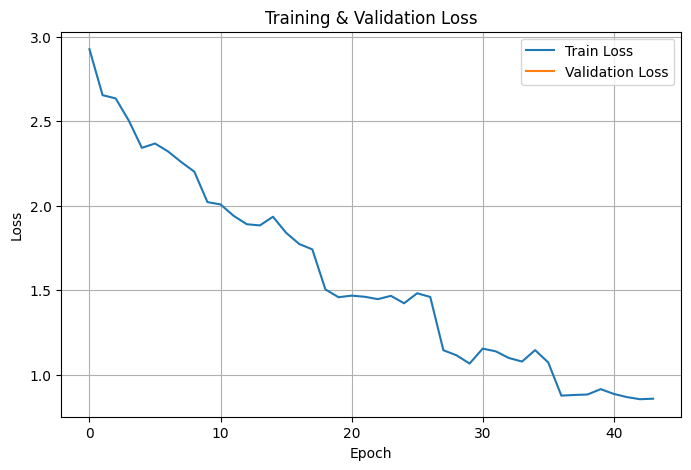

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_loss_per_epoch, label="Train Loss")
plt.plot(val_loss_per_epoch, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Step 10: Final test accuracy
test_results = trainer.evaluate(final_ds["test"])
print("✅ Test Accuracy:", test_results["eval_accuracy"])

✅ Test Accuracy: 0.4094616639477977


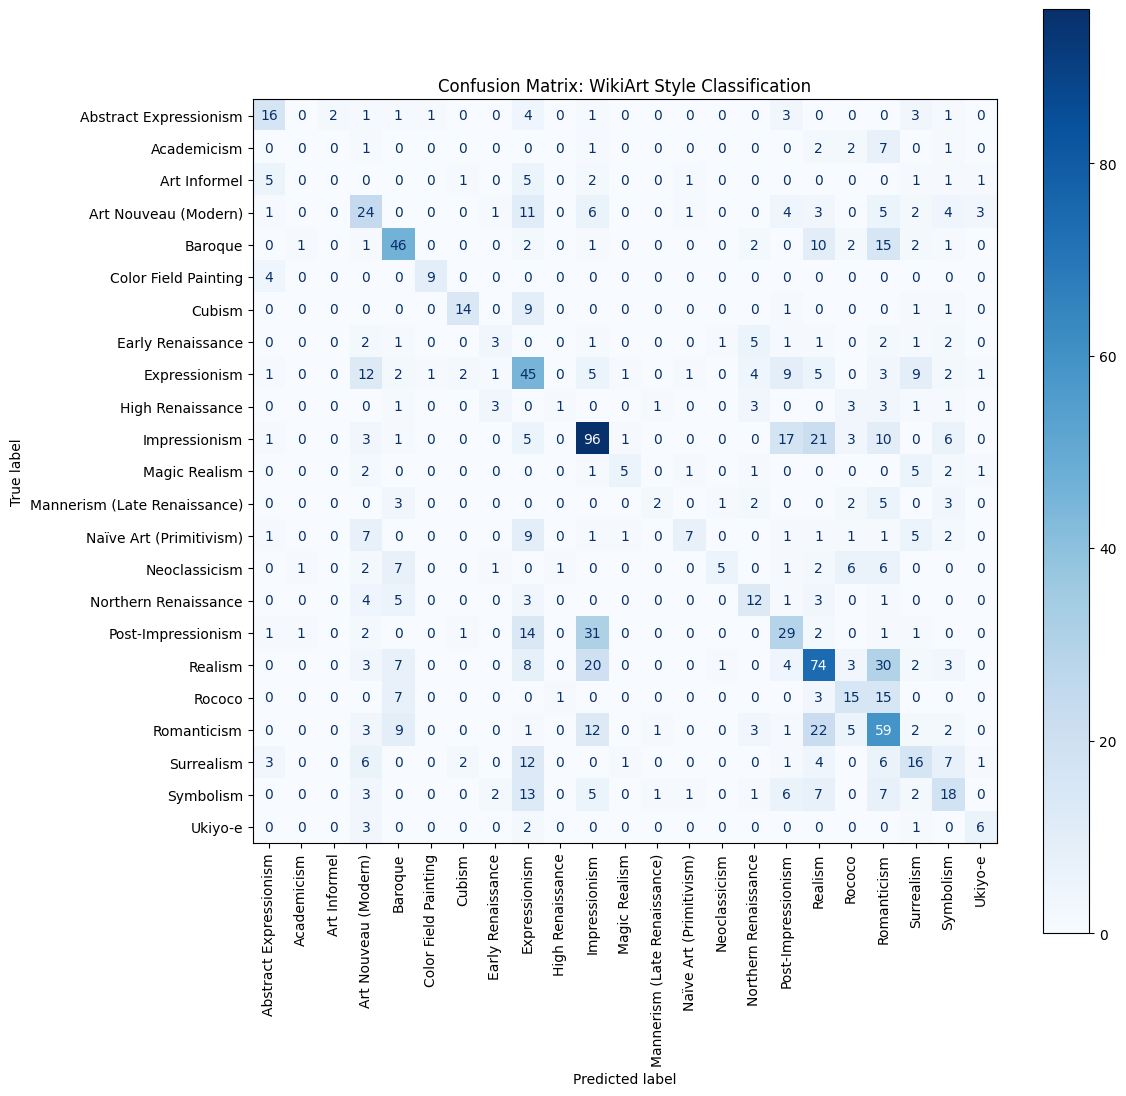

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
predictions = trainer.predict(final_ds["test"])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)

# Confusion matrix with labels
labels = [final_ds["test"].features["style"].int2str(i) for i in range(len(style_names))]
cm = confusion_matrix(y_true, y_pred)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, ax=ax, cmap='Blues')
plt.title("Confusion Matrix: WikiArt Style Classification")
plt.show()
